# Data Ingestion Pipeline

### Loading npy(s)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [6]:
processed_dataset  = "processed_data"

In [7]:
from scipy.ndimage import zoom
import os

# numero di sample richiesti
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []
anchors            = []

for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    anchor             = jnp.array(np.load("%s/anchors/anchor_%d.npy"                       % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(zoom(voxelization,(1./2.,1./2.,1./2.)))
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    anchors.append(anchor)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
30 su 301
60 su 301
90 su 301
120 su 301
150 su 301
180 su 301
210 su 301
240 su 301
270 su 301
300 su 301


# Train Test Split

In [8]:
indici_train = np.arange(len(voxelizations)) < int(len(voxelizations) * .8)
indici_test  = ~indici_train         

# Subvoxelgrid Transform
Che tipo di trasformazione bisogna applicare alla subvoxel grid estratta prima di utilizzarla?

In [57]:
class SubvoxelgridTransform:
    def __init__(self,n):
        self.grid = self._init_grid(n)
        self.ball = self._emptyball(n)
    
    def _init_grid(self,n):
        return np.array(
        [
            [
                [
                    [x,y,z]
                    for z  in np.linspace(0,1,2*n)
                ]
                for y  in np.linspace(0,1,2*n)
            ]
            for x  in np.linspace(0,1,2*n)
        ]
        )

    def _emptyball(self,n):
        r = np.array([
            [
                [
                        (i**2 + j**2 + k**2) <= 1
                    for k in np.linspace(-1,1,2*n)
                ]
                for j in np.linspace(-1,1,2*n)
            ]
            for i in np.linspace(-1,1,2*n)
        ])
        return r
    
    ##############################################################################################
    
    def identity(self,SV):
        return SV
    
    
    def rotational_invariance(self,SV):
        # calcolo i nuovi punti
        points = self.grid[ (SV * self.ball) > 0.5].reshape(-1,3)
        if len(points) < 2.:
            # non ci sono atomi nella selezione!
            return SV

        points = points - points.mean(axis = 0)

        original_points = points.copy()

        U,s,Vt = np.linalg.svd(points)


        projection = points @ Vt.T
        classifica = np.argmax( np.abs(projection), axis = 0)
        S  =   np.sign( projection[classifica,[0,1,2]] )
        V  =   S[None,:] * Vt.T
        points = points @ V

        ## costruisco la voxelgrid
        ret  = np.zeros(self.grid.shape[:-1])

        stdpoints = (points - points.min()) / (points.max() - points.min())


        for p in stdpoints:
                i = int(p[0] * (SV.shape[0] - 1) )
                j = int(p[1] * (SV.shape[1] - 1) )
                k = int(p[2] * (SV.shape[2] - 1) )
                ret[i,j,k] = 1.
        return ret

A = np.random.uniform(size = (10,10,10))
axs = plt.figure().subplots(nrows = 1,ncols = 2).flatten()
axs[0].imshow(( (A>0.5) * SubvoxelgridTransform(5)._emptyball(5)).mean(axis = 0))
axs[1].imshow(SubvoxelgridTransform(5).rotational_invariance(A).mean(axis = 0))

# Batch extraction

In [58]:
def extract_dataset(N = 150,window_size = 8):
    X_train,F_train,Y_train = [],[],[]
    X_test ,F_test ,Y_test  = [],[],[]
     
    selezionati_train = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi    
                                len(voxelizations)     # il training set
                            )[indici_train] , size = N
                        )
    selezionati_test = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi
                                len(voxelizations)     # il test set
                            )[indici_test] , size = N  
                        )
    
    ####  Invarianza rotazionale
    
    transform = SubvoxelgridTransform(window_size)
    
    ##### TRAIN
    for sample in selezionati_train:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_train.append( transform.rotational_invariance 
                        (
                           curr_vox[ 
                            (i+window_size) - window_size: (i+window_size) + window_size,
                            (j+window_size) - window_size: (j+window_size) + window_size,
                            (k+window_size) - window_size: (k+window_size) + window_size
                          ] 
                        )
                      )
        F_train.append(finger_prints[sample])
        Y_train.append( np.sum((center  - centers_of_mass[sample])**2) )
    
    
    #### TEST
    for sample in selezionati_test:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_test.append( 
                        transform.rotational_invariance 
                        (
                            curr_vox[ 
                                (i+window_size) - window_size: (i+window_size) + window_size,
                                (j+window_size) - window_size: (j+window_size) + window_size,
                                (k+window_size) - window_size: (k+window_size) + window_size
                              ] 
                        )
                        )
        F_test.append(finger_prints[sample])
        Y_test.append( np.sum((center  - centers_of_mass[sample])**2) )        
        
    return (jnp.array(X_train),jnp.array(F_train),jnp.array(Y_train)), (jnp.array(X_test),jnp.array(F_test),jnp.array(Y_test))

# Reward

In [59]:
def predict(W,Wf,X,F):
    O     = (
         jnp.linspace(-int(W.shape[0]/2),int(W.shape[0]/2),W.shape[0])[:,None,None]**2 +
         jnp.linspace(-int(W.shape[1]/2),int(W.shape[1]/2),W.shape[1])[None,:,None]**2 +
         jnp.linspace(-int(W.shape[2]/2),int(W.shape[2]/2),W.shape[2])[None,None,:]**2    
    ) < 4.
    Y_hat = jax.vmap(lambda x,f: (x*(W + O*(f @ Wf))).sum())(X,F)
    return Y_hat
def corr(x,y):
    return ((x - x.mean())@(y - y.mean()))/(jnp.linalg.norm(x - x.mean())*jnp.linalg.norm(y - y.mean()))
def reward(W,Wf,X,F,Y):
    Y_hat = predict(W,Wf,X,F)
    return corr(Y_hat,Y)
reward = jax.jit(reward)
grad   = jax.jit(jax.grad(reward, argnums = (0,1)))

# Computational Loop

L'idea é quella di utilizzare una <b> ascesa del gradiente stocastica </b> per massimizzare la correlazione tra l'output del modello e la distanza al quadrato tra il <b> punto che rappresenta il centro della voxelgrid selezionata e il punto effettivo di attachment del ligando </b>.
Il modello prende in ingresso 
1. la subvoxelgrid centrata nel punto di cui si vuole valutare la bontá
2. la finger print del ligando
I parametri $\theta$ sono rappresentati da un tensore ${\bf W}$ che agisce come un funzionale lineare nello spazio delle subvoxelgrid di ordine $n$ e un vettore ${\bf W_f}$ che agisce invece come funzionale nello spazio delle fingerprint

In [60]:
%matplotlib qt5

In [63]:
window = 10               # grandezza della finestra
np.random.seed(123)       # fisso il seed per la riproducibilitá 
W      = np.random.normal(size = (2*window,2*window,2*window))
Wf     = np.random.normal(size = 2048) * 1e-5 # small!
plt.figure()

# dati del grafico

validation_scores = []

# ciclo di calcolo

for i in range(2000):
    (X_train_curr, F_train_curr,Y_train_curr) , (X_test_curr, F_test_curr,Y_test_curr) = extract_dataset(window_size=window)
    g  = grad(W,Wf,X_train_curr,F_train_curr,Y_train_curr)
    W  += 1e-1 * g[0]
    Wf += 1e-1 * g[1]
    print( i, reward(W,Wf,X_train_curr,F_train_curr,Y_train_curr), reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)  )
   
    validation_score = reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)
    validation_scores.append(validation_score)
    
    plt.scatter(i, validation_score, s = 50., color = 'black')
    if i % 10 == 0:
        plt.show()
        plt.pause(1e-12)

0 -0.1347179 0.03319102
1 -0.09053558 0.07253364
2 0.069750905 -0.0766836
3 0.03750845 -0.07445348
4 0.0028423108 -0.18522741
5 -0.022586823 -0.060790714
6 -0.068086185 0.15545924
7 0.06522648 -0.11340056
8 0.036327176 -0.011385024
9 0.040580057 0.07911457
10 -0.052999765 -0.0037016317
11 0.053492412 -0.028754652
12 0.098152675 0.104058415
13 0.042762958 0.0015201843
14 0.18371548 0.1899724
15 0.1013861 -0.036740743
16 0.07137645 0.13634016
17 0.06590818 0.015720721
18 0.09577353 0.034732368
19 0.2174529 0.11421974
20 0.09661971 -0.0017118718
21 0.15869565 0.09351509
22 0.077251256 0.09650153
23 0.21823663 0.12047539
24 0.16971743 0.029362435
25 0.1478417 0.14920132
26 0.13899952 0.11863147
27 0.15760449 0.099609494
28 0.13624924 0.08872064
29 0.0045211934 0.08898189
30 0.041464593 -0.037076954
31 0.1730181 0.117853194
32 0.032545075 0.049947206
33 0.17529224 0.1162414
34 0.24734303 0.1356274
35 0.121840015 0.2725291
36 0.23889276 -0.12152247
37 0.17665216 0.2933684
38 0.14423567 0.107

322 0.3031407 0.3340563
323 0.36682388 0.3324677
324 0.3715121 0.21392171
325 0.34298062 0.17970008
326 0.36593223 0.30033317
327 0.44580415 0.25151297
328 0.2569862 0.20004353
329 0.30920482 0.28366506
330 0.37794212 0.26250967
331 0.44577482 0.23056796
332 0.3761569 0.32654068
333 0.39220154 0.28253576
334 0.25500542 0.3342751
335 0.34388718 0.33117434
336 0.2712998 0.2956013
337 0.432152 0.2025348
338 0.30185524 0.24814214
339 0.44567752 0.16075772
340 0.44119892 0.34508312
341 0.28573516 0.24294166
342 0.16328953 0.26880437
343 0.3047568 0.270362
344 0.4600266 0.32242253
345 0.37107417 0.28186044
346 0.44721135 0.2165289
347 0.32467595 0.28742462
348 0.3157623 0.21447562
349 0.38968402 0.36179918
350 0.2567381 0.25430542
351 0.29501653 0.25779635
352 0.47019693 0.17871156
353 0.2919912 0.3187454
354 0.44707334 0.39248985
355 0.41033533 0.22692865
356 0.40341127 0.28967538
357 0.39403236 0.29180455
358 0.45460576 0.15723245
359 0.3864521 0.32313982
360 0.40034482 0.24106595
361 0.35

646 0.522104 0.27663997
647 0.36020932 0.3087419
648 0.36324218 0.40490925
649 0.48514694 0.33055708
650 0.49685028 0.40092212
651 0.50925404 0.34537673
652 0.4011754 0.26878718
653 0.3778058 0.35611418
654 0.44633654 0.14788567
655 0.40748993 0.29056525
656 0.46586558 0.31495124
657 0.42156583 0.23460907
658 0.53572404 0.316263
659 0.341128 0.26258639
660 0.4563571 0.361601
661 0.3670961 0.31972718
662 0.4214367 0.4219753
663 0.4033312 0.3744241
664 0.5076269 0.35946286
665 0.40281537 0.18593945
666 0.3513811 0.46802032
667 0.5166886 0.35090607
668 0.47058406 0.3478351
669 0.4211548 0.32532609
670 0.33240047 0.35104498
671 0.40526974 0.38727635
672 0.4971584 0.28728175
673 0.25506985 0.27646688
674 0.38842484 0.25625083
675 0.42642987 0.27127767
676 0.34660593 0.31721997
677 0.48336455 0.4052555
678 0.43145823 0.33032265
679 0.49764657 0.21118957
680 0.38903534 0.3670506
681 0.42480725 0.3214049
682 0.48481783 0.3602696
683 0.43755686 0.28675288
684 0.35075304 0.12668811
685 0.4019154

970 0.35754937 0.44537246
971 0.41643232 0.36834216
972 0.46219215 0.42137942
973 0.46637213 0.3933125
974 0.47323972 0.38350892
975 0.4609842 0.40817395
976 0.49877077 0.47624943
977 0.38140884 0.37795448
978 0.47329304 0.3384871
979 0.35453722 0.34462136
980 0.5286932 0.42285404
981 0.47283405 0.4740118
982 0.43526575 0.34008536
983 0.46574807 0.461543
984 0.35002324 0.34458637
985 0.45836368 0.33425295
986 0.41094097 0.31239182
987 0.44116548 0.4687285
988 0.52715135 0.2780638
989 0.41992807 0.445613
990 0.4844522 0.4067718
991 0.38676178 0.36710796
992 0.45328948 0.42827958
993 0.4973662 0.38049915
994 0.43939865 0.325603
995 0.4209269 0.35350746
996 0.40392685 0.33634374
997 0.40137678 0.3022885
998 0.50890005 0.33742923
999 0.48035148 0.30727774
1000 0.43822736 0.3286079
1001 0.43541044 0.43065718
1002 0.41514537 0.3446949
1003 0.46505854 0.35287577
1004 0.3842309 0.30859482
1005 0.4585059 0.26895845
1006 0.51378703 0.44578236
1007 0.3317111 0.48043635
1008 0.4742119 0.37998495
1

1284 0.4624516 0.3828313
1285 0.48468196 0.37369856
1286 0.47609746 0.3310886
1287 0.48888323 0.49183822
1288 0.45848334 0.35492793
1289 0.5024574 0.35326353
1290 0.53997266 0.34322396
1291 0.5403821 0.29301134
1292 0.41430542 0.30481198
1293 0.48869726 0.34278226
1294 0.47304797 0.2688796
1295 0.4676875 0.44253215
1296 0.44843572 0.3950458
1297 0.525639 0.34235945
1298 0.4971621 0.47091955
1299 0.40398705 0.41541892
1300 0.52295464 0.53644514
1301 0.44042408 0.3701132
1302 0.45473033 0.30596417
1303 0.41225788 0.3827769
1304 0.5295876 0.33932957
1305 0.4737528 0.37802598
1306 0.335835 0.31896114
1307 0.33859697 0.32394016
1308 0.5040583 0.45773366
1309 0.43977508 0.41357836
1310 0.45539853 0.27981257
1311 0.4794508 0.3683215
1312 0.5008377 0.3870973
1313 0.44756368 0.34158555
1314 0.52631176 0.29160118
1315 0.4679947 0.45534793
1316 0.42435014 0.34767303
1317 0.35545585 0.3547674
1318 0.46872875 0.39177313
1319 0.52326125 0.39624172
1320 0.5641938 0.41855845
1321 0.38179153 0.30951655

1597 0.4570081 0.4192973
1598 0.39649346 0.37889624
1599 0.5433543 0.37110823
1600 0.5815 0.42411274
1601 0.46631083 0.33523703
1602 0.5210073 0.343783
1603 0.41388744 0.38739637
1604 0.4005846 0.41274187
1605 0.45162302 0.42252633
1606 0.5345483 0.31096044
1607 0.47410828 0.42838165
1608 0.47125575 0.34270397
1609 0.4267464 0.3937011
1610 0.54729503 0.2949778
1611 0.4719733 0.45034522
1612 0.45662382 0.5045732
1613 0.41932583 0.5039625
1614 0.51629806 0.4280134
1615 0.48548713 0.511635
1616 0.46280625 0.32223615
1617 0.54618084 0.3652401
1618 0.49231845 0.5354637
1619 0.44677597 0.38302097
1620 0.3810957 0.33664665
1621 0.5458574 0.50670123
1622 0.47082466 0.23468006
1623 0.48812783 0.32963726
1624 0.47172517 0.2532777
1625 0.54081684 0.41669235
1626 0.4583576 0.3621805
1627 0.4846781 0.2522995
1628 0.53805745 0.5281734
1629 0.45927203 0.40142033
1630 0.4426592 0.41169405
1631 0.38899067 0.3527139
1632 0.47774798 0.4504232
1633 0.4032987 0.33523935
1634 0.59962034 0.42701474
1635 0.50

1911 0.4765943 0.47263074
1912 0.5117611 0.34064198
1913 0.5175101 0.38085705
1914 0.4589407 0.42874846
1915 0.48242915 0.51227444
1916 0.5124688 0.36854675
1917 0.40653634 0.41585886
1918 0.5185342 0.3608338
1919 0.4808905 0.4894106
1920 0.55271953 0.39205244
1921 0.5307158 0.38293895
1922 0.5476108 0.34317484
1923 0.47584242 0.19527963
1924 0.5156186 0.43371227
1925 0.5278575 0.25401396
1926 0.48767295 0.4650331
1927 0.4086831 0.44245842
1928 0.41559136 0.4632484
1929 0.3732641 0.47822016
1930 0.5535129 0.47154528
1931 0.50630546 0.48626712
1932 0.5041086 0.37871352
1933 0.44807795 0.3689488
1934 0.5335497 0.37098557
1935 0.3822977 0.30788812
1936 0.49244988 0.42761567
1937 0.44328365 0.3660438
1938 0.55640084 0.34325293
1939 0.545534 0.29860675
1940 0.59590787 0.36098084
1941 0.49532616 0.45623797
1942 0.45312074 0.38842335
1943 0.4163672 0.35007468
1944 0.56070775 0.31226757
1945 0.5121988 0.3137249
1946 0.5006642 0.5013761
1947 0.42824614 0.36825442
1948 0.47762418 0.52726626
1949

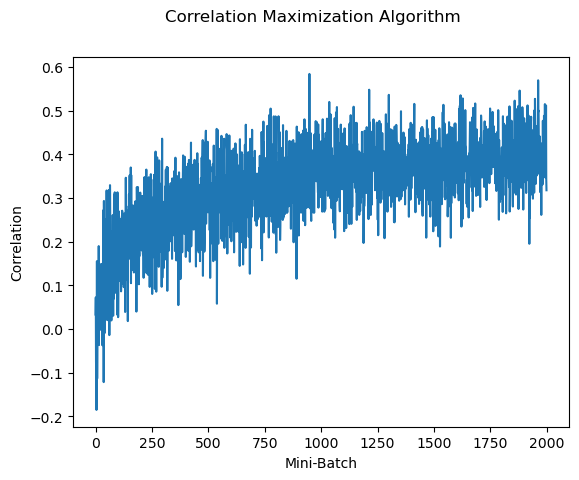

In [64]:
%matplotlib inline
plt.suptitle("Correlation Maximization Algorithm")
plt.ylabel("Correlation")
plt.xlabel("Mini-Batch")
plt.plot(validation_scores)

# Salvo i pesi

In [65]:
np.save("W.npy", W)
np.save("Wf.npy", Wf)

# Carico i pesi

In [66]:
W  = np.load("W.npy")
Wf = np.load("Wf.npy")

(0.0, 0.0)

# Test

Data una voxelizzazione carico gli anchor point e ne calcolo la distanza con il punto di attachment.
Per testare la bontá del classificatore precedente viene analizzata la correlazione tra l'output e la distanza effettiva

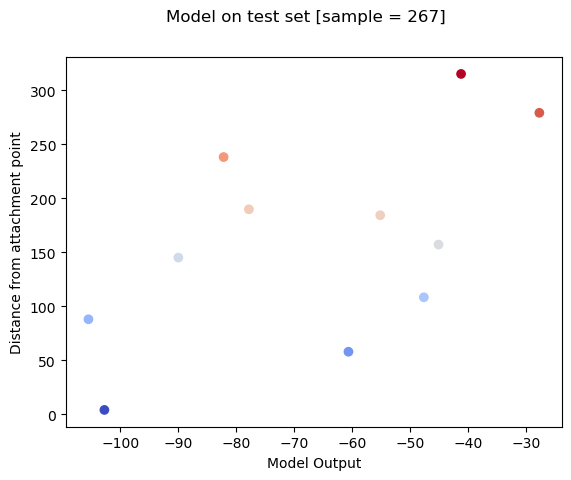

In [77]:
sample = np.arange(len(voxelizations))[indici_test][27]

# costrusico la voxgrid paddata

Nx,Ny,Nz  = voxelizations[sample].shape
curr_vox  = jnp.pad(
                voxelizations[sample],
                pad_width = (
                    (window,window),
                    (window,window),
                    (window,window)
                )
            )

# imposto la trasfromazione

transform = SubvoxelgridTransform(window)

points = []
for a in anchors[sample]:
    correct_distance = jnp.sum( ( a - centers_of_mass[sample] )**2 )
    
    # trovo il voxel associato al punto di ancoraggip
    x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs[sample]
    x,y,z = a
    i,j,k = (
             int( (x - x_min)/(x_max - x_min) * Nx ),
             int( (y - y_min)/(y_max - y_min) * Ny ),
             int( (z - z_min)/(z_max - z_min) * Nz )
    )

    # estraggo la subvoxelgrid
    subvox = transform.rotational_invariance(curr_vox[ 
                            (i+window) - window: (i+window) + window,
                            (j+window) - window: (j+window) + window,
                            (k+window) - window: (k+window) + window
                          ])
    # estraggo il farmaco
    f      = finger_prints[sample]
    Y_hat =  predict(W,Wf,subvox[None,:],f[None,:])[0]
    
    points.append([Y_hat,correct_distance])

points = np.array(points)
plt.xlabel("Model Output")
plt.ylabel("Distance from attachment point")
plt.suptitle("Model on test set [sample = %d]" % sample)
plt.scatter(points[:,0],points[:,1],c = points[:,1], cmap = 'coolwarm')

Si osservi come l'output del calssificatore sia effettivamente in grado di "correlare" con la distanza effettiva (punti vicini al punto di ancoraggio producono un output piccolo)